In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *

import DM_Hackstein  ## this contains procedures following Phsirkov+16


In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_IGM = {
    'IGM' : ['primordial'],
}

In [16]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from scipy import integrate


rho_crit = Planck15.critical_density0.value # g/cm3
omega_b = Planck15.Ob0
omega_m = Planck15.Om0
omega_L = Planck15.Ode0
m_p = 1.67e-24 # g
mu_e = 1.16
c = 2.99e8 # m/s
H_0 = 1./Planck15.hubble_time.value

n_e = rho_crit * omega_b  / m_p / mu_e

def DM(z, f_IGM=0.82):
    return n_e * f_IGM *c/H_0* integrate.quad( lambda z: (1+z)/( omega_m*(1+z)**3 + omega_L )**0.5, 0, z)[0]
    #return n_e * f_IGM * Distance( unit=u.pc, z = z, cosmology = Planck15).parsecb
    

Find fit for results of primordial IGM model with DM $ = C \times z \times 1000 \rm~ pc~ cm^{-3}$

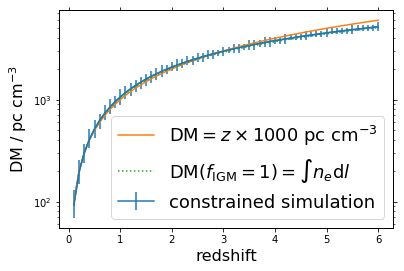

In [9]:
fig, ax = plt.subplots()

PlotAverageEstimate( measure='DM', scenario=scenario_IGM, label='constrained simulation', ax=ax)

C_primordial = 1

ax.plot( redshift_bins, redshift_bins*1000*C_primordial, label=r"DM$ = z \times 1000$ pc cm$^{-3}$" )
ax.plot( redshift_bins, [DM(z , f_IGM=1.) for z in redshift_bins], label=r"DM$(f_{\rm IGM}=1) = \int n_e {\rm d}l$", linestyle=':' )

ax.legend(fontsize=18)
AllSidesTicks(ax)

In [11]:
## compare to pshirkov estimate

## n_e = 1.8e-7 cm^-3 implicitly assumes ~83% of baryons in ionized IGM

B0 = 1e-4 # muG  at n_0=1.8e-7
l_c = 100 # Mpc    correlation length
z_max = 3.0

t0 = time()

LoS = DM_Hackstein.Sightline( B0, l_c, z_max )
print('initialized in %.0f seconds' % (time() - t0))


initialized in 86 seconds


In [12]:
t0 = time()
zs = LoS.zarray
#zs, dens = LoS.CreateArrays( z_max )
#print('%.0f seconds, now for the DM' % (time() - t0))
#DMs = HowLong( LoS.DispersionMeasure, dens, zs )
#RMs = HowLong( LoS.RotationMeasure, dens, zs )

N=1000

DMs = np.array([ LoS.DispersionMeasure( *LoS.CreateArrays( z_max, zarray=zs )[::-1] ) for i in range(N)])
print('%.0f seconds, now for the RM' % (time() - t0))
RMs = np.array([ np.abs(LoS.RotationMeasure( *LoS.CreateArrays( z_max, zarray=zs )[::-1])) for i in range(N)])
print('%.0f seconds, now for the plot' % (time() - t0))

195 seconds, now for the RM
389 seconds, now for the plot


In [13]:
DM_mean_log = np.mean( np.log10(DMs), axis=0)
DM_mean = 10.**DM_mean_log
DM_std = np.std( np.log10(DMs), axis=0)
DM_err = np.array( [ DM_mean - 10.**(DM_mean_log-DM_std), 10**( DM_mean_log+DM_std) - DM_mean ] )
RM_mean_log = np.mean( np.log10(RMs), axis=0)
RM_mean = 10.**RM_mean_log
#RM_mean = np.mean( RMs, axis=0 )
RM_std = np.std( np.log10(RMs), axis=0)
RM_err = np.array( [ RM_mean - 10.**(RM_mean_log-RM_std), 10**( RM_mean_log+RM_std) - RM_mean ] )
#RM_mean = 10.**np.mean( np.log10(RMs), axis=0)
#RM_std = np.std( RMs, axis=0)

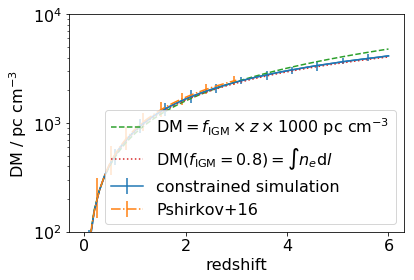

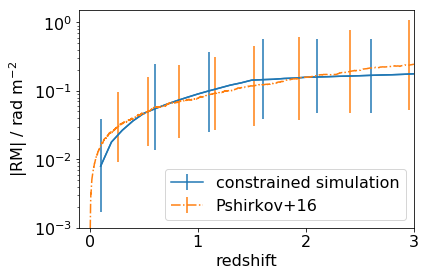

In [19]:
fig, ax = plt.subplots()

f_IGM = 0.8
tmp = { 'IGM': ['primordial_C%.0f' % (1000*f_IGM) ]}

PlotAverageEstimate( measure='DM', scenario=tmp, label='constrained simulation', ax=ax, errorevery=5)

#ax.plot( zs[:-1], DM_mean, label='Pshirkov+15')
ax.errorbar( zs[:-1], DM_mean, yerr=DM_err, label='Pshirkov+16', errorevery=500, linestyle='-.')

ax.plot( redshift_bins, redshift_bins*1000*f_IGM, label=r"DM$ = f_{\rm IGM} \times z \times 1000$ pc cm$^{-3}$", linestyle='--' )
ax.plot( redshift_bins, [DM(z , f_IGM=f_IGM ) for z in redshift_bins], label=r"DM$(f_{\rm IGM}=%.1f) = \int n_e {\rm d}l$" % f_IGM, linestyle=':' )



'''
for DM in DMs:
    axs[0].plot( zs[:-1], DM, label='Pshirkov+15', linestyle=':')
for RM in RMs:
    axs[1].plot( zs[:-1], RM, label='Pshirkov+15', linestyle=':')
'''

ax.set_ylim(1e2,1e4)
ax.legend(fontsize=16, loc=4)
#AllSidesTicks(ax)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()


fig, ax = plt.subplots()

PlotAverageEstimate( measure='RM', scenario=tmp, label='constrained simulation', ax=ax, errorevery=5)
#ax.plot( zs[:-1], RM_mean, label='Pshirkov+15')
ax.errorbar( zs[:-1], RM_mean, yerr=RM_err, label='Pshirkov+16', errorevery=500, linestyle='-.')

ax.set_ylim(1e-3,1.5e0)
ax.set_xlim(-.1,3)
ax.legend(fontsize=16, loc=4)
ax.tick_params(axis='both', which='major', labelsize=16)
#AllSidesTicks(ax)

plt.show()



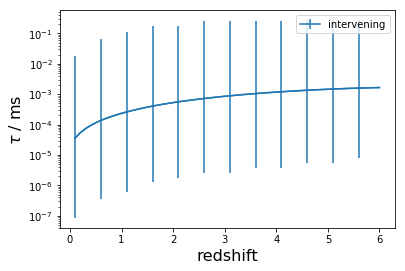

In [9]:
scenario_nointer = {
#    'IGM' : ['primordial'],
#    'Host' : ['Rodrigues18'],
#    'Inter' : ['Rodrigues18'],
#    'Local' : ['Piro18/wind'],
}
scenario_inter = scenario_nointer.copy()
scenario_inter['Inter'] = ['Rodrigues18']

fig, ax = plt.subplots()

PlotAverageEstimate( measure='tau', scenario=scenario_inter, label='intervening', errorevery=5, ax=ax)
#PlotAverageEstimate( measure='tau', scenario=scenario_nointer, label='no invervening', errorevery=5, ax=ax)

#ax.set_ylim(1e-3,1.5e0)
#ax.set_xlim(-.1,3)
plt.legend()
#AllSidesTicks(ax)

plt.show()

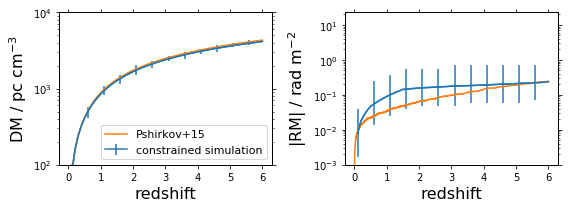

In [11]:

fig, axs = plt.subplots( 1, 2, figsize=(8,3))
tmp = { 'IGM': ['primordial_C800']}
#tmp = { 'IGM': ['primordial']}
PlotAverageEstimate( measure='DM', scenario=tmp, label='constrained simulation', ax=axs[0], errorevery=5)
PlotAverageEstimate( measure='RM', scenario=tmp, label='constrained simulation', ax=axs[1], errorevery=5)

axs[0].plot( zs[:-1], DM_mean, label='Pshirkov+15')
axs[1].plot( zs[:-1], RM_mean, label='Pshirkov+15')

#axs[0].plot( zs[:-1], 10.**np.mean(np.log10(DMs), axis=0), label='Pshirkov+15')
#axs[1].plot( zs[:-1], 10.**np.mean(np.log10(RMs), axis=0), label='Pshirkov+15')

'''
for DM in DMs:
    axs[0].plot( zs[:-1], DM, label='Pshirkov+15', linestyle=':')
for RM in RMs:
    axs[1].plot( zs[:-1], RM, label='Pshirkov+15', linestyle=':')
#'''

axs[0].set_ylim(1e2,1e4)
axs[1].set_ylim(1e-3,2.3e1)
#axs[1].set_ylim(1,20)
axs[0].legend(fontsize=11, loc=4)
for ax in axs:
    AllSidesTicks(ax)
plt.tight_layout()
plt.show()


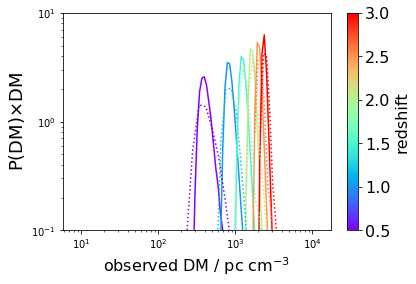

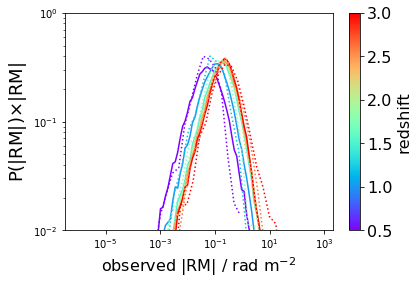

In [22]:
ix, = np.where( np.diff((zs*2).astype('i')) > 0 )

fig, ax = plt.subplots()

PlotLikelihoodEvolution( measure='DM', scenario={'IGM':['primordial_C800']}, redshift_bins=redshift_bins[4:30:5], ax=ax)

for i, color in zip(ix, Rainbow(ix.astype('f'))):
    P, x = Histogram( DMs[:,i], density=True, log=True, bins=20)
    PlotLikelihood( P=P, x=x, measure='DM', ax=ax, color=color, linestyle=':' )
ax.set_ylim(1e-1,1e1)
plt.show()

fig, ax = plt.subplots()

PlotLikelihoodEvolution( measure='RM', scenario={'IGM':['primordial_C800']}, redshift_bins=redshift_bins[4:30:5], ax=ax)

for i, color in zip(ix, Rainbow(ix.astype('f'))):
    P, x = Histogram( RMs[:,i], density=True, log=True, bins=20)
    PlotLikelihood( P=P, x=x, measure='RM', ax=ax, color=color, linestyle=':' )
ax.set_ylim(1e-2,1e0)
plt.show()


In [20]:
p = 0.1
(1000*p)**0.5/(p*1000)

0.1

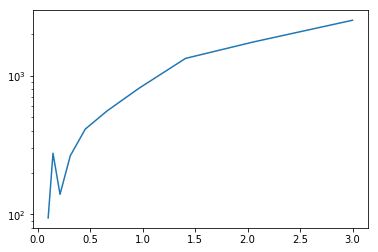

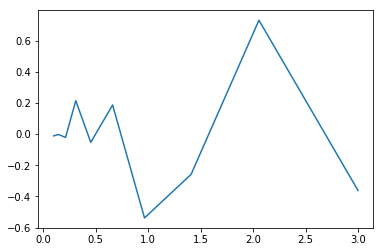

In [26]:
plt.plot( zbins, DMbins)
plt.yscale('log')
plt.show()
plt.plot( zbins, RMbins)
#plt.yscale('log')
plt.show()


In [25]:
d = Planck15.lookback_distance(zs).value
l = 10.*2.3*(1+zs)**(-1.5)
B = np.ones(zs.size)

i = (d//l).astype('i')
n_flip = i[-1]+1
r = np.cos(np.random.uniform(0,2*np.pi,n_flip))

B *= r[i]



In [26]:
B

array([-0.20079405, -0.20079405, -0.20079405, ...,  0.11641205,
       -0.14611487,  0.02223296])